# Load data

In [1]:
from scipy.io import loadmat

data = loadmat("concatenated_1000ms_from250_speed10_bin100.mat")
features = data["features"]
position = data["position"]

print features.shape, position.shape

(12600, 76) (12600, 2)



# Split into training and test set

Currently using first 80% as training and last 20% as test set.

In [2]:
nr_samples = features.shape[0]
nr_train = 10100
nr_test = nr_samples - nr_train

train_X = features[:nr_train]
train_Y = position[:nr_train]
test_X = features[nr_train:]
test_Y = position[nr_train:]

print train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

(10100, 76) (10100, 2) (2500, 76) (2500, 2)


## Helper function to calculate mean distance

In [3]:
import numpy as np

def mean_distance(estimator, X, y):
    pred_y = estimator.predict(X)
    return np.mean(np.sqrt(np.sum((pred_y - y) ** 2, axis=1)))

def mean_distance_scoring(estimator, X, y):
    return -mean_distance(estimator, X, y)

# Random forest

## First take with default parameters

The result is better than with linear model. Overfitting is a problem.

In [4]:
from sklearn.ensemble.forest import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(train_X, train_Y)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(rf, train_X, train_Y), mean_distance(rf, test_X, test_Y), rf.score(test_X, test_Y))

Train mean distance 7.980243, test mean distance: 27.067161, test R^2 score 0.640180


## Grid search

In [5]:
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'n_estimators': [10, 100, 1000], 
                     'max_features': ['auto', 'sqrt', 0.5],
                     'max_depth': [None, 10, 20],
                     'min_samples_leaf': [1, 10, 100]}]

cv = GridSearchCV(RandomForestRegressor(n_jobs=2), tuned_parameters, scoring=mean_distance_scoring, cv=5, verbose=2)
cv.fit(train_X, train_Y)

print cv.best_params_, cv.best_score_

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(cv, train_X, train_Y), mean_distance(cv, test_X, test_Y), cv.score(test_X, test_Y))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.8s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.9s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.5s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.7s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.7s
[CV] max_features=auto, n_estimators=100, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=100, ma

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:  8.2min
[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed: 20.6min



[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  26.4s
[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  24.5s
[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  21.9s
[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  23.4s
[CV] max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 
[CV]  max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 -   0.4s
[CV] max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 
[CV]  max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 -   0.4s
[CV] max_feat

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed: 40.2min
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 45.3min finished



{'max_features': 0.5, 'n_estimators': 1000, 'max_depth': None, 'min_samples_leaf': 1} -29.7917964143
Train mean distance 6.575540, test mean distance: 24.759257, test R^2 score -24.759257


/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


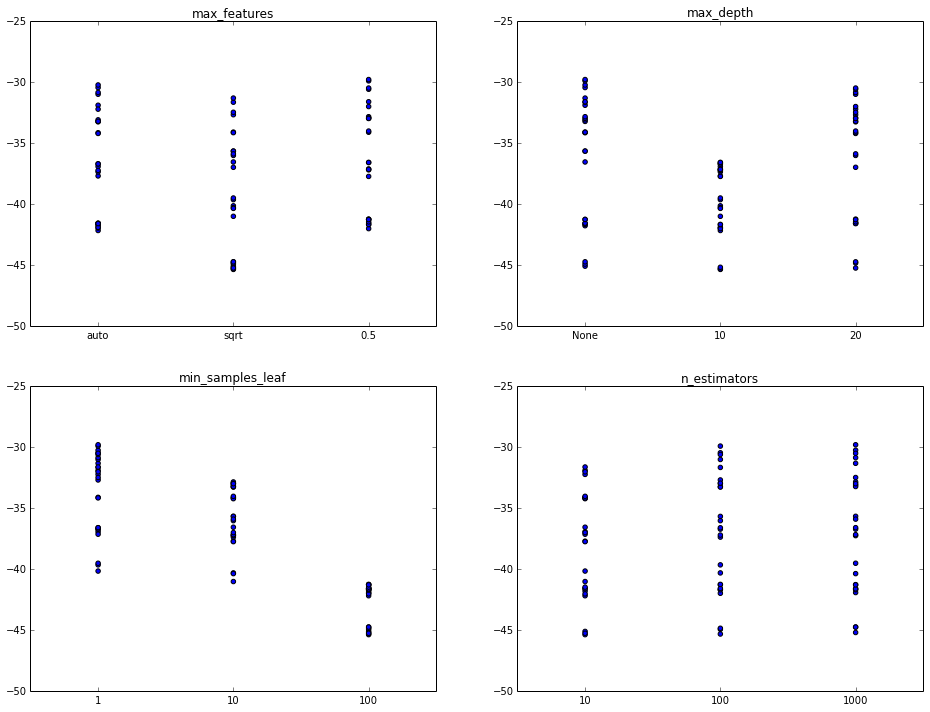

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

for params in tuned_parameters:
    plt.figure(figsize=(16,12))
    ncols = int(math.ceil(math.sqrt(len(params))))
    nrows = int(math.ceil(len(params) / ncols))
    for i, (param, values) in enumerate(params.iteritems()):
        #print i, param, values
        value_to_index = {v:i for i,v in enumerate(values)}
        scores = []
        indexes = []
        for cv_tuple in cv.grid_scores_:
            scores.append(cv_tuple.mean_validation_score)
            value = cv_tuple.parameters[param]
            indexes.append(value_to_index[value])
        plt.subplot(nrows,ncols,i)
        plt.scatter(indexes, scores)
        plt.xticks(range(len(values)), values)
        plt.title(param)
    plt.show()

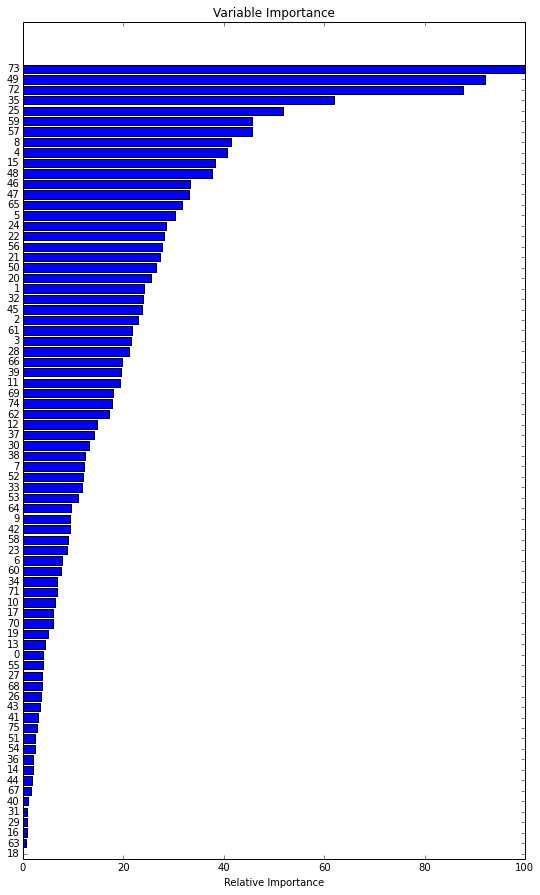

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot feature importance
feature_importance = cv.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(9,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, sorted_idx)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

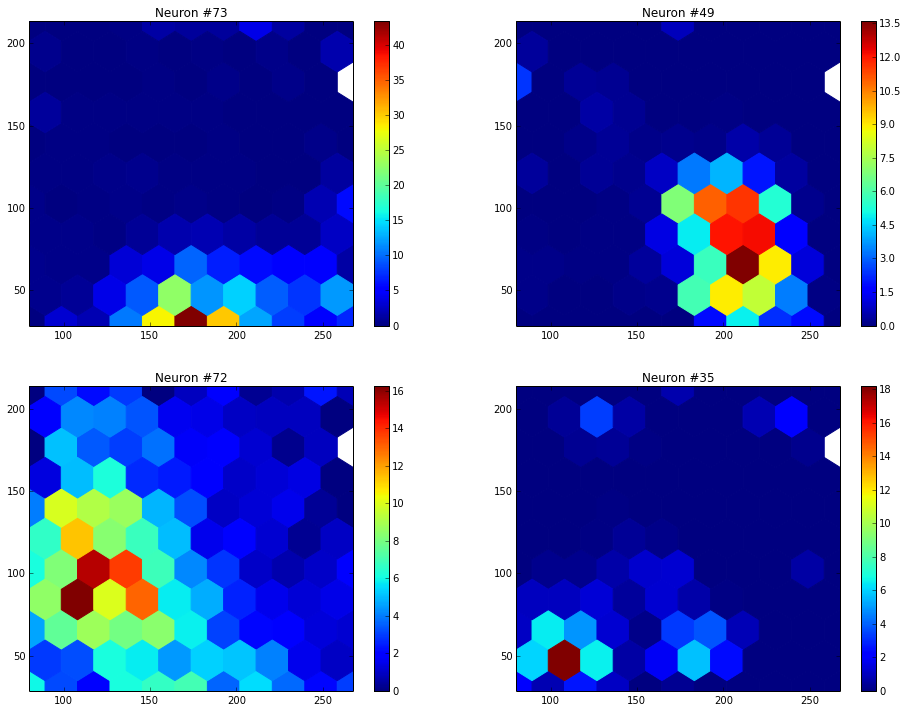

In [8]:
plt.figure(figsize=(16,12))
for i in xrange(1,5):
    plt.subplot(2,2,i)
    plt.hexbin(position[...,0], position[...,1], features[...,sorted_idx[-i]], gridsize = 10)
    plt.colorbar()
    plt.title("Neuron #%d" % sorted_idx[-i])

# Extremely randomized trees

Worked slightly better with default parameters, but no major leap.

In [9]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor()
et.fit(train_X, train_Y)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(et, train_X, train_Y), mean_distance(et, test_X, test_Y), et.score(test_X, test_Y))

Train mean distance 0.000000, test mean distance: 26.639076, test R^2 score 0.664623


In [10]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'n_estimators': [10, 100, 1000], 
                     'max_features': ['auto', 'sqrt', 0.5],
                     'max_depth': [None, 10, 20],
                     'min_samples_leaf': [1, 10, 100]}]

cv = GridSearchCV(ExtraTreesRegressor(n_jobs=2), tuned_parameters, scoring=mean_distance_scoring, cv=5, verbose=2)
cv.fit(train_X, train_Y)

print cv.best_params_, cv.best_score_

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(cv, train_X, train_Y), mean_distance(cv, test_X, test_Y), cv.score(test_X, test_Y))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.9s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.8s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.8s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.6s
[CV] max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=10, max_depth=None, min_samples_leaf=1 -   0.6s
[CV] max_features=auto, n_estimators=100, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, n_estimators=100, ma

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:  6.8min
[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed: 17.6min



[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  16.2s
[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  18.4s
[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  16.9s
[CV] max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 
[CV]  max_features=auto, n_estimators=1000, max_depth=10, min_samples_leaf=10 -  18.4s
[CV] max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 
[CV]  max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 -   0.4s
[CV] max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 
[CV]  max_features=auto, n_estimators=10, max_depth=10, min_samples_leaf=100 -   0.4s
[CV] max_feat

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed: 32.4min
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 36.4min finished



{'max_features': 'auto', 'n_estimators': 1000, 'max_depth': None, 'min_samples_leaf': 1} -28.9882559391
Train mean distance 0.000000, test mean distance: 24.306768, test R^2 score -24.306768


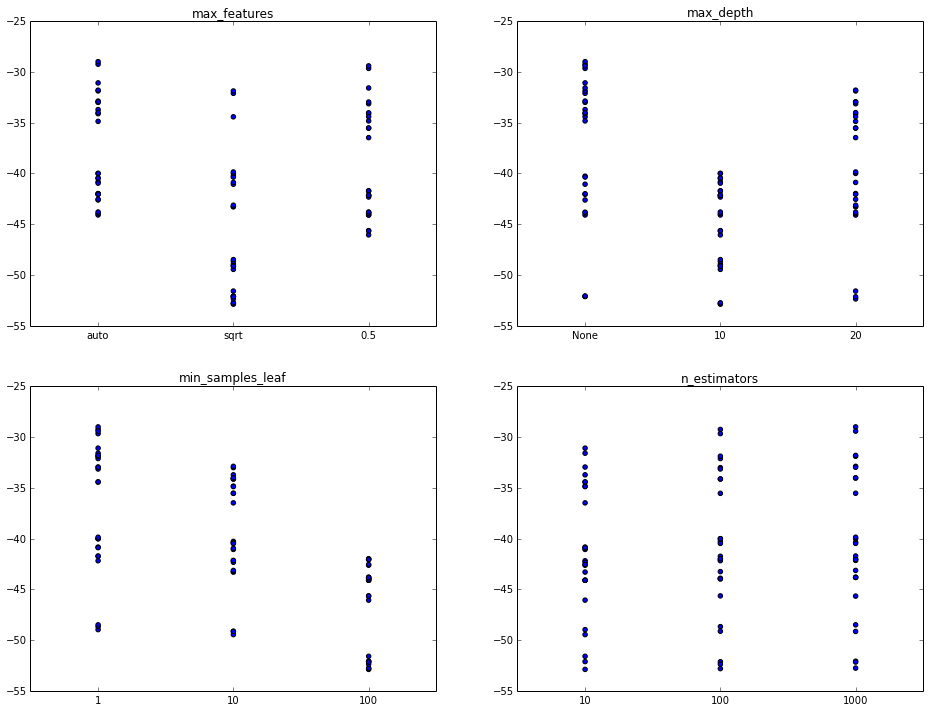

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

for params in tuned_parameters:
    plt.figure(figsize=(16,12))
    ncols = int(math.ceil(math.sqrt(len(params))))
    nrows = int(math.ceil(len(params) / ncols))
    for i, (param, values) in enumerate(params.iteritems()):
        #print i, param, values
        value_to_index = {v:i for i,v in enumerate(values)}
        scores = []
        indexes = []
        for cv_tuple in cv.grid_scores_:
            scores.append(cv_tuple.mean_validation_score)
            value = cv_tuple.parameters[param]
            indexes.append(value_to_index[value])
        plt.subplot(nrows,ncols,i)
        plt.scatter(indexes, scores)
        plt.xticks(range(len(values)), values)
        plt.title(param)
    plt.show()

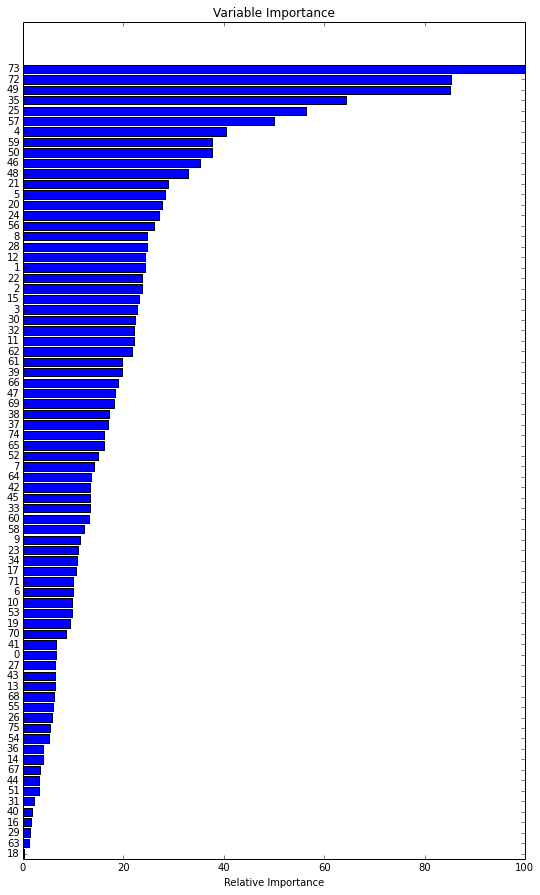

In [12]:
# Plot feature importance
feature_importance = cv.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(9,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, sorted_idx)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Gradient Boosted Regression Trees

## Helper class for multiple output regression

In [13]:
import sklearn

class VectorRegression(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y):
        n, m = y.shape
        # Fit a separate regressor for each column of y
        self.estimators_ = [sklearn.base.clone(self.estimator).fit(X, y[:, i])
                               for i in range(m)]
        return self

    def predict(self, X):
        # Join regressors' predictions
        res = [est.predict(X)[:, np.newaxis] for est in self.estimators_]
        return np.hstack(res)

    def set_params(self, **params):
        self.estimator.set_params(**params)
        return self

## First try defaults

Clearly underfits.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = VectorRegression(GradientBoostingRegressor())
gb.fit(train_X, train_Y)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(gb, train_X, train_Y), mean_distance(gb, test_X, test_Y), gb.score(test_X,  test_Y))

Train mean distance 31.002405, test mean distance: 31.530167, test R^2 score 0.607061


## Grid search

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'learning_rate': [1, 0.5, 0.1], 
                     'n_estimators': [10, 100, 1000],
                     'max_depth': [3, 5, 10],
                     'subsample': [1.0, 0.5, 0.1]}]

gb = VectorRegression(GradientBoostingRegressor())
cv = GridSearchCV(gb, tuned_parameters, scoring=mean_distance_scoring, cv=5, n_jobs=2, verbose=2)
cv.fit(train_X, train_Y)

print cv.best_params_, cv.best_score_

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(cv, train_X, train_Y), mean_distance(cv, test_X, test_Y), cv.score(test_X, test_Y))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
